In [1]:
import pandas as pd
import json
import tqdm

# Convert to csv and check file

In [2]:
def get_playlist_df(dPlaylist):

  sPlaylistName = dPlaylist["name"]
  #bCollaborative = (dPlaylist["collaborative"] != "false")
  iPlaylistId = dPlaylist["pid"]
  #iModified = dPlaylist["modified_at"]
  #iNumberofTracks = dPlaylist["num_tracks"]
  #iNumberofAlbums = dPlaylist["num_albums"]
  #iNumberofArtists = dPlaylist["num_artists"]
  iNumberofFollowers = dPlaylist["num_followers"]
  lTracks = dPlaylist["tracks"]
  #iNumberofEdits = dPlaylist["num_edits"]
  #iDuration = dPlaylist["duration_ms"]
  dfTracks = pd.DataFrame.from_dict(lTracks)
  dfTracks["playlist_name"] = sPlaylistName
  dfTracks["pid"] = iPlaylistId
  dfTracks["followers"] = iNumberofFollowers

  return dfTracks


In [2]:
def get_playlist_csv(iSlice=0, sDataPath="/content/dataset/data/"):

  sFilename = f"data/mpd.slice.{iSlice*1000}-{iSlice*1000+999}.json"
  dFile = json.load(open(sDataPath+sFilename))

  dfAllTracks = pd.DataFrame()
  #for dPlaylist in tqdm.tqdm(dFile["playlists"]):
  for dPlaylist in dFile["playlists"]:
    dfTracks = get_playlist_df(dPlaylist)
    dfAllTracks = pd.concat((dfAllTracks, dfTracks))
  
  return dfAllTracks

In [4]:
#To turn the json slices into ssv

dfAllTracks = pd.DataFrame()

sDataPath = "/Users/egcanmac/Desktop/COMP 537/music/spotify_million_playlist_dataset/"

with tqdm.tqdm(total=100*10) as pbar:
  for seg in range(100):
    dfAllTracks = pd.DataFrame()
    for i in range(10):
      dfTracks = get_playlist_csv(i, sDataPath)
      dfAllTracks = pd.concat((dfAllTracks, dfTracks))
      pbar.update(1)
    dfAllTracks.to_csv(f"{sDataPath}csv/{seg}.csv")
    break

  1%|          | 10/1000 [01:31<2:31:29,  9.18s/it]


In [9]:
import sys
def get_object_size(obj):
    """Returns the size of an object in MB."""
    size = sys.getsizeof(obj)
    print(f" Size of the object is {round(size / (1024**3),4)} GB")

get_object_size(dfAllTracks)

 Size of the object is 0.3733 GB


# Get playlists as sentences
Each song is treated as a unique word

In [28]:
dSongVocab = {}
dSongCounts = {} 

iId = 1

#sDataPath = "/content/dataset/data/"
sDataPath = "/Users/egcanmac/Desktop/COMP 537/music/spotify_million_playlist_dataset/"

for iSlice in tqdm.tqdm(range(1000)):

  sFilename = f"data/mpd.slice.{iSlice*1000}-{iSlice*1000+999}.json"
  dFile = json.load(open(sDataPath+sFilename))
  
  for dPlaylist in dFile["playlists"]:

    lTracks = dPlaylist["tracks"]

    for dTrack in lTracks:

      if dTrack["track_uri"] not in dSongVocab.keys():

        #print(iId)

        dSongVocab[dTrack["track_uri"]] = iId
        dSongCounts[dTrack["track_uri"]] = 1
        iId += 1
      
      else:
        dSongCounts[dTrack["track_uri"]] += 1



100%|██████████| 1000/1000 [05:16<00:00,  3.15it/s]


In [29]:
dSongVocab.keys()

2262292

In [30]:
len(dSongCounts)

2262292

In [28]:
#pd.to_pickle(dSongVocab, "dSongVocab.pkl")
#pd.to_pickle(dSongCounts, "dSongCounts.pkl")

In [9]:
#dSongVocab = pd.read_pickle("dSongVocab.pkl")
#dSongCounts = pd.read_pickle("dSongCounts.pkl")

In [10]:
print(f"Number of unique songs: {len(dSongVocab.keys())}")

Number of unique songs: 2262292


In [12]:
iMINIMUM_SONG_OCCURENCE = 5
dSongVocabModified = {k:v for k,v in dSongCounts.items() if v>=iMINIMUM_SONG_OCCURENCE}
fpercentage_left = len(dSongVocabModified.keys()) / len(dSongCounts.keys())
print(f"{1-fpercentage_left} songs occur less than {iMINIMUM_SONG_OCCURENCE} times.")

0.7350735448828003 songs occur less than 5 times.


<Axes: >

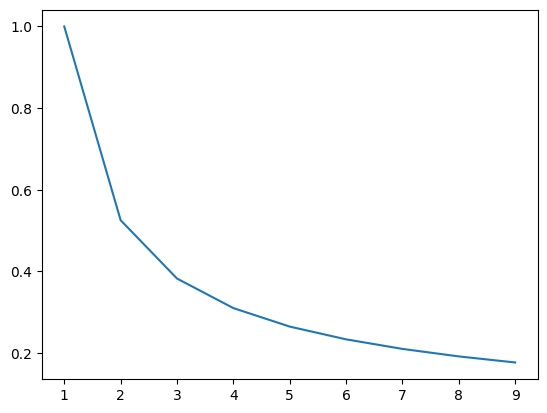

In [13]:
df_number_of_songs_left = pd.DataFrame(index=range(1,10), columns=["number_of_songs", "percentage"])

for iMSO in range(1, 10):
    dSongVocabModified = {k:v for k,v in dSongCounts.items() if v>=iMSO}
    fpercentage_left = len(dSongVocabModified.keys()) / len(dSongCounts.keys())
    df_number_of_songs_left.loc[iMSO, "number_of_songs"] = len(dSongVocabModified.keys())
    df_number_of_songs_left.loc[iMSO, "percentage"] = fpercentage_left

df_number_of_songs_left["percentage"].plot()

In [33]:
iMINIMUM_SONG_OCCURENCE = 2
dSongVocabModified = {k:v for k,v in dSongCounts.items() if v>=iMINIMUM_SONG_OCCURENCE}
fpercentage_left = len(dSongVocabModified.keys()) / len(dSongCounts.keys())
print(f"{1-fpercentage_left} songs occur less than {iMINIMUM_SONG_OCCURENCE} times.")

0.47448295799127616 songs occur less than 2 times.


In [15]:
len(dSongVocabModified)

1188873

In [35]:
iInd = 0
dSongVocabModified2 = {}
for k,v in dSongVocabModified.items():
    dSongVocabModified2[k] = iInd
    iInd +=1

In [37]:
max(dSongVocabModified2.values())

1188872

In [53]:
#pd.to_pickle(dSongVocabModified2, "dSongVocabModified_LAST.pkl")

In [86]:
#pd.to_pickle(dSongVocabModified, "dSongVocabModified_2.pkl")
dSongVocabModified2 = pd.read_pickle("dSongVocabModified_LAST.pkl")

In [41]:
def get_sentences_from_slice(iSlice, song_dict=dSongVocabModified, sDataPath="/content/dataset/data/"):

  lAllSentences = []

  sFilename = f"data/mpd.slice.{iSlice*1000}-{iSlice*1000+999}.json"
  dFile = json.load(open(sDataPath+sFilename))

  for dPlaylist in dFile["playlists"]:

    lTracks = dPlaylist["tracks"]
    lSentence = []
    iSentenceLen = 0

    for dTrack in lTracks:

      if dTrack["track_uri"] in song_dict.keys():
        lSentence.append(song_dict[dTrack["track_uri"]])
        iSentenceLen += 1 

    
    if iSentenceLen >= 2:
      lAllSentences.append(lSentence)

  return lAllSentences

In [42]:
lAllSentences = []

for iSlice in tqdm.tqdm(range(1000)):

  lSentences = get_sentences_from_slice(iSlice,
                                        song_dict=dSongVocabModified2,
                                        sDataPath="/Users/egcanmac/Desktop/COMP 537/music/spotify_million_playlist_dataset/")

  lAllSentences = lAllSentences + lSentences

100%|██████████| 1000/1000 [05:36<00:00,  2.97it/s]


In [43]:
print("Number of playlists left: ", len(lAllSentences))

Number of playlists left:  999773


In [44]:
get_object_size(lAllSentences)

NameError: name 'get_object_size' is not defined

In [54]:
#pd.to_pickle(lAllSentences, "lAllSentencesFINAL2.pkl")

In [87]:
lAllSentences = pd.read_pickle("lAllSentencesFINAL2.pkl")

# Skipgram

In [16]:
# This is a list of all the playlists with the name of the song
# replaced by a number key

#lAllSentences = pd.read_pickle("lAllSentences.pkl")

In [45]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {}'.format(self.epoch, loss))
        self.epoch += 1

In [85]:
EPOCHS = 8
VECTOR_SIZE = 128
SKIPGRAM = False
WINDOW = 16
MIN_COUNT = 1

model = Word2Vec(sentences=lAllSentences,
                 epochs=EPOCHS,
                 vector_size=VECTOR_SIZE,
                 sg=SKIPGRAM, 
                 window=WINDOW,
                 compute_loss=True,
                 callbacks=[callback()],
                 min_count=MIN_COUNT,
                 workers=8)

model.save(f"cbow_epochs{EPOCHS}_vectorsize{VECTOR_SIZE}_window{WINDOW}_mincount{MIN_COUNT}_FINAL.model")

Loss after epoch 0: 9423107.0
Loss after epoch 1: 14707870.0
Loss after epoch 2: 19135898.0
Loss after epoch 3: 23000550.0
Loss after epoch 4: 26639956.0
Loss after epoch 5: 30097058.0
Loss after epoch 6: 33375132.0
Loss after epoch 7: 35282564.0


In [74]:
model = Word2Vec.load(f"../skipgram_epochs{EPOCHS}_vectorsize{VECTOR_SIZE}_window{WINDOW}_mincount{MIN_COUNT}.model")

In [48]:
# Get the list of words in the vocabulary
vocab_words = list(model.wv.index_to_key)

# Print the first 10 words in the vocabulary
print(vocab_words[:10])

[1322, 3687, 1383, 1854, 2693, 2679, 1320, 2676, 1147, 3522]


In [49]:
# Get the 10 most similar words to "word"
similar_words = model.wv.most_similar(1336, topn=10)

# Print the similar words and their cosine similarity scores
for word, score in similar_words:
    print(word, score)

34333 0.9176754951477051
1371 0.9174685478210449
544 0.9168476462364197
25611 0.9165571928024292
12698 0.9128198623657227
39453 0.9113340377807617
8824 0.9100887179374695
1313 0.9081800580024719
37092 0.9072404503822327
1381 0.9066891670227051


In [50]:
# Get the 10 most similar words to "word"
similar_words = model.wv.most_similar([1336], topn=10)

# Print the similar words and their cosine similarity scores
for word, score in similar_words:
    print(word, score)

34333 0.9176754951477051
1371 0.9174685478210449
544 0.9168476462364197
25611 0.9165571928024292
12698 0.9128198623657227
39453 0.9113340377807617
8824 0.9100887179374695
1313 0.9081800580024719
37092 0.9072404503822327
1381 0.9066891670227051


In [51]:
similar_words

[(34333, 0.9176754951477051),
 (1371, 0.9174685478210449),
 (544, 0.9168476462364197),
 (25611, 0.9165571928024292),
 (12698, 0.9128198623657227),
 (39453, 0.9113340377807617),
 (8824, 0.9100887179374695),
 (1313, 0.9081800580024719),
 (37092, 0.9072404503822327),
 (1381, 0.9066891670227051)]

In [57]:
def get_names(modified_dict=dSongVocabModified2):

    sDataPath = "/Users/egcanmac/Desktop/COMP 537/music/spotify_million_playlist_dataset/"

    dSongNames = {}

    track_uris = modified_dict.keys()

    for iSlice in tqdm.tqdm(range(1000)):

        sFilename = f"data/mpd.slice.{iSlice*1000}-{iSlice*1000+999}.json"
        dFile = json.load(open(sDataPath+sFilename))
    
        for dPlaylist in dFile["playlists"]:

            lTracks = dPlaylist["tracks"]

            for dTrack in lTracks:

                if dTrack["track_uri"] not in dSongNames.keys():
                    if dTrack["track_uri"] in track_uris:
                        dSongNames[dTrack["track_uri"]] = (dTrack["artist_name"], dTrack["track_name"])
    
    return dSongNames

dSongNames = get_names()

100%|██████████| 1000/1000 [04:30<00:00,  3.70it/s]


In [61]:
len(dSongNames.keys())

1188873

In [62]:
len(dSongVocabModified2)

1188873

In [66]:
len({v: k for k,v in dSongVocabModified2.items()})

1188873

In [63]:
dSongVocabModified2

{'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI': 0,
 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak': 1,
 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv': 2,
 'spotify:track:1AWQoqb9bSvzTjaLralEkT': 3,
 'spotify:track:1lzr43nnXAijIGYnCT8M8H': 4,
 'spotify:track:0XUfyU2QviPAs6bxSpXYG4': 5,
 'spotify:track:68vgtRHr7iZHpzGpon6Jlo': 6,
 'spotify:track:3BxWKCI06eQ5Od8TY2JBeA': 7,
 'spotify:track:7H6ev70Weq6DdpZyyTmUXk': 8,
 'spotify:track:2PpruBYCo4H7WOBJ7Q2EwM': 9,
 'spotify:track:2gam98EZKrF9XuOkU13ApN': 10,
 'spotify:track:4Y45aqo9QMa57rDsAJv40A': 11,
 'spotify:track:1HwpWwa6bnqqRhK8agG4RS': 12,
 'spotify:track:20ORwCJusz4KS2PbTPVNKo': 13,
 'spotify:track:7k6IzwMGpxnRghE7YosnXT': 14,
 'spotify:track:1Bv0Yl01xBDZD4OQP93fyl': 15,
 'spotify:track:4omisSlTk6Dsq2iQD7MA07': 16,
 'spotify:track:7xYnUQigPoIDAMPVK79NEq': 17,
 'spotify:track:6d8A5sAx9TfdeseDvfWNHd': 18,
 'spotify:track:4pmc2AxSEq6g7hPVlJCPyP': 19,
 'spotify:track:215JYyyUnrJ98NK3KEwu6d': 20,
 'spotify:track:0uqPG793dkDDN7sCUJJIVC': 21,
 'spotify:track:19Js

In [79]:
dSongNamesRev = {v: k for k,v in dSongNames.items()}

In [80]:
len(dSongNamesRev)

1154404

In [81]:
song_names = [k[0] + ' · ' + k[1] for k,v in dSongNamesRev.items()]

In [82]:
len(song_names)

1154404

In [83]:
import pickle

with open('song_names_word2vec.pickle', 'wb') as f:
    pickle.dump(song_names, f)

In [84]:
dSongNames

{'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI': ('Missy Elliott',
  'Lose Control (feat. Ciara & Fat Man Scoop)'),
 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak': ('Britney Spears', 'Toxic'),
 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv': ('Beyoncé', 'Crazy In Love'),
 'spotify:track:1AWQoqb9bSvzTjaLralEkT': ('Justin Timberlake',
  'Rock Your Body'),
 'spotify:track:1lzr43nnXAijIGYnCT8M8H': ('Shaggy', "It Wasn't Me"),
 'spotify:track:0XUfyU2QviPAs6bxSpXYG4': ('Usher', 'Yeah!'),
 'spotify:track:68vgtRHr7iZHpzGpon6Jlo': ('Usher', 'My Boo'),
 'spotify:track:3BxWKCI06eQ5Od8TY2JBeA': ('The Pussycat Dolls', 'Buttons'),
 'spotify:track:7H6ev70Weq6DdpZyyTmUXk': ("Destiny's Child", 'Say My Name'),
 'spotify:track:2PpruBYCo4H7WOBJ7Q2EwM': ('OutKast',
  'Hey Ya! - Radio Mix / Club Mix'),
 'spotify:track:2gam98EZKrF9XuOkU13ApN': ('Nelly Furtado', 'Promiscuous'),
 'spotify:track:4Y45aqo9QMa57rDsAJv40A': ('Jesse McCartney',
  'Right Where You Want Me - Radio Edit Version'),
 'spotify:track:1HwpWwa6bnqqRhK8agG4RS': ('Je

In [69]:
#pd.to_pickle(dSongNames, "dSongNamesFinal.pkl")
#pd.to_pickle(dSongVocabModified2, "dSongVocabModified2Final.pkl")

In [114]:
dSongNamesReverse = {f"{v[0]} {v[1]}":k for k,v in dSongNames.items()}

In [110]:
#pd.to_pickle(dSongNamesReverse, "dSongNamesReverse.pkl")

In [115]:
dSongNamesReverse

{'Missy Elliott Lose Control (feat. Ciara & Fat Man Scoop)': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
 'Britney Spears Toxic': 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak',
 'Beyoncé Crazy In Love': 'spotify:track:0ljxwe66xkaQg2Scx9nCuL',
 'Justin Timberlake Rock Your Body': 'spotify:track:1AWQoqb9bSvzTjaLralEkT',
 "Shaggy It Wasn't Me": 'spotify:track:1lzr43nnXAijIGYnCT8M8H',
 'Usher Yeah!': 'spotify:track:0XUfyU2QviPAs6bxSpXYG4',
 'Usher My Boo': 'spotify:track:68vgtRHr7iZHpzGpon6Jlo',
 'The Pussycat Dolls Buttons': 'spotify:track:3BxWKCI06eQ5Od8TY2JBeA',
 "Destiny's Child Say My Name": 'spotify:track:7H6ev70Weq6DdpZyyTmUXk',
 'OutKast Hey Ya! - Radio Mix / Club Mix': 'spotify:track:2PpruBYCo4H7WOBJ7Q2EwM',
 'Nelly Furtado Promiscuous': 'spotify:track:2gam98EZKrF9XuOkU13ApN',
 'Jesse McCartney Right Where You Want Me - Radio Edit Version': 'spotify:track:5SUAUJEmXqQ4ZxhSm4nZX6',
 'Jesse McCartney Beautiful Soul': 'spotify:track:6yT86bU8625XcaQhuXYY38',
 "Jesse McCartney Leavin'": 'spotify:t

In [85]:
dSongVocabModified

{'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI': 6841,
 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak': 13205,
 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv': 16914,
 'spotify:track:1AWQoqb9bSvzTjaLralEkT': 9066,
 'spotify:track:1lzr43nnXAijIGYnCT8M8H': 23173,
 'spotify:track:0XUfyU2QviPAs6bxSpXYG4': 25363,
 'spotify:track:68vgtRHr7iZHpzGpon6Jlo': 9082,
 'spotify:track:3BxWKCI06eQ5Od8TY2JBeA': 6293,
 'spotify:track:7H6ev70Weq6DdpZyyTmUXk': 13785,
 'spotify:track:2PpruBYCo4H7WOBJ7Q2EwM': 21726,
 'spotify:track:2gam98EZKrF9XuOkU13ApN': 17396,
 'spotify:track:4Y45aqo9QMa57rDsAJv40A': 813,
 'spotify:track:1HwpWwa6bnqqRhK8agG4RS': 10855,
 'spotify:track:20ORwCJusz4KS2PbTPVNKo': 5650,
 'spotify:track:7k6IzwMGpxnRghE7YosnXT': 6794,
 'spotify:track:1Bv0Yl01xBDZD4OQP93fyl': 2229,
 'spotify:track:4omisSlTk6Dsq2iQD7MA07': 9328,
 'spotify:track:7xYnUQigPoIDAMPVK79NEq': 6993,
 'spotify:track:6d8A5sAx9TfdeseDvfWNHd': 2374,
 'spotify:track:4pmc2AxSEq6g7hPVlJCPyP': 6606,
 'spotify:track:215JYyyUnrJ98NK3KEwu6d': 2329,
 'spot